In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
path = 'data/data.csv'
df = pd.read_csv(path, encoding='ISO-8859-1') # Using a different encoding while info is fixed

In [3]:
df.sample(5)

,Authors,Year,Paper,Country,MDS,Data Source Primary,Data Source Secondary,Algorithm,Task,Cross Validation,Performance Metric,Sample Size,Dataset,Goal,Abstract,Person,Notes
3,Kadirvelu et al.,2023.0,A wearable motion capture suit and machine lea...,UK,Ataxia (Friedreich's),NaN,Full-body kinematic data from wearable sensors,GPP,8-meter walk (8-MW) and 9-hole peg test (9-HPT),LOPOCV,"R^2, RMSE","18 participants (9 FA patients, 9 healthy cont...",Own Recruitment,Utilize wearable sensor technology and machine...,Friedreichs ataxia (FA) is caused by the down...,IC,NaN
61,Huang et al.,2023.0,Recent trends in wearable device used to detec...,China,Freezing of Gait,NaN,Wearables,"SVM, KNN, NN, LSTM (Various Reviewed)","Walking, TUG, ADL (Various Reviewed)",Various Reviewed,Various Reviewed,1-131 (Various Reviewed),Various,Review: Provide a comprehensive overview of ex...,Background: The occurrence of freezing of gait...,NC,NaN
118,Oliveira et al.,2022.0,Technologies to support the diagnosis and/or t...,Italy,"TS,",NaN,"EEG, fMRI, MRI, Eye-tracking, phones, VR","DL, SVM, CNN",Various different studies,Various Reviewed,"Accuracy, Sensitivty, Secificity, AUC",14 - 146 Patients,NaN,Comprehensive review of current trends regardi...,"In recent years, there has been a great intere...",NC,NaN
48,Cala et al,2023.0,Machine Learning Assessment of Spasmodic Dysph...,Italy,Dystonia,NaN,Voice recordings,"KNN, SVM, RF",Speech,LOSO,"Accuracy, Precision, Sensitivity, Specificity,...",28,Own Recruitment,Develop non-invasive system using ML classifyi...,Adductor spasmodic dysphonia is a type of adul...,NC,NaN
16,Guarín et al.,2023.0,An Artificial Intelligence Video-Based Assessm...,USA,Bradykinesia,NaN,Video recordings,GB,Finger tapping,LOPOCV,NaN,NaN,NaN,NaN,NaN,IC,NaN


In [4]:
# Converting Year to int. Filling NaN with 0
df['Year'] = df['Year'].fillna(0).astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Authors                223 non-null    object
 1   Year                   224 non-null    int64 
 2   Paper                  223 non-null    object
 3   Country                220 non-null    object
 4   MDS                    221 non-null    object
 5   Data Source Primary    6 non-null      object
 6   Data Source Secondary  221 non-null    object
 7   Algorithm              222 non-null    object
 8   Task                   187 non-null    object
 9   Cross Validation       170 non-null    object
 10  Performance Metric     200 non-null    object
 11  Sample Size            189 non-null    object
 12  Dataset                188 non-null    object
 13  Goal                   200 non-null    object
 14  Abstract               196 non-null    object
 15  Person                 

In [6]:
# df[df['Country'] == 'US, Canada, UK']

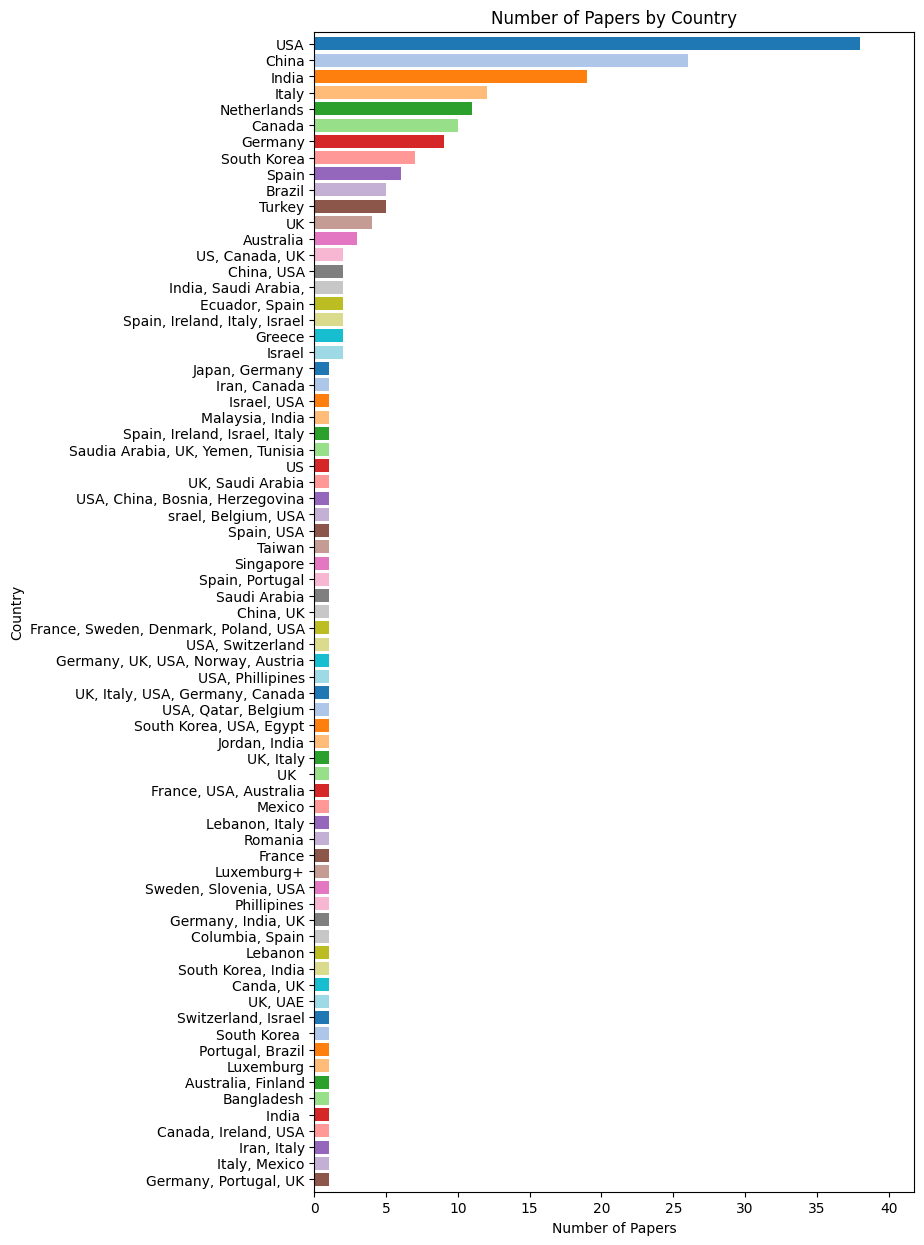

In [24]:
# Plot the horizontal bar graph with spacing between bars
country_counts = df['Country'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(country_counts.index, country_counts.values, color=cm.tab20.colors[:len(country_counts)])
# Set the x-axis label
max_count = country_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Papers')
plt.ylabel('Country')
plt.title('Number of Papers by Country')

# for i, v in enumerate(country_counts.values):
#         plt.text(v + 1, i, str(v))

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=1.5, bottom=0.05)
# plt.grid(axis='x', linestyle='--', alpha=0.3)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()

In [8]:
df['MDS'].value_counts()

PD                                                                          50
Freezing of Gait                                                            30
TS                                                                          26
Bradykinesia                                                                23
Dyskinesia                                                                  19
Dystonia                                                                     9
Dyskinesia, PD                                                               9
Isolated Dystonia                                                            5
Bradykinesia                                                                 5
Ataxia                                                                       4
Cervical Dystonia                                                            4
Ataxia (Multiple Sclerosis)                                                  3
PD                                                  

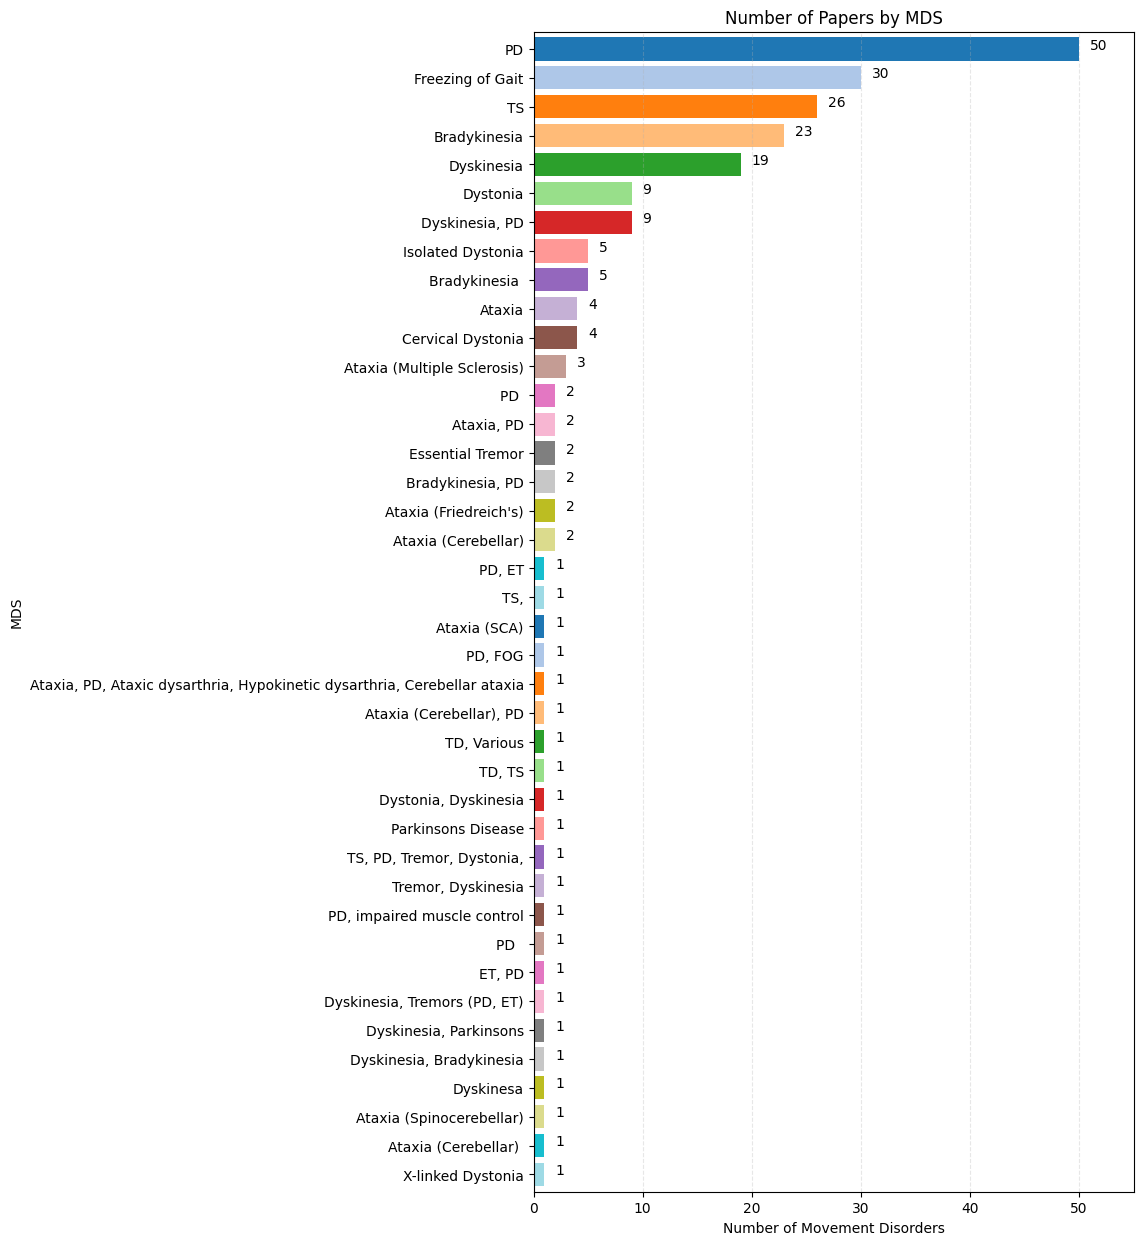

In [15]:
# Plot the horizontal bar graph with spacing between bars
mds_counts = df['MDS'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(mds_counts.index, mds_counts.values, color=cm.tab20.colors[:len(mds_counts)])
# Set the x-axis label
max_count = mds_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Movement Disorders')
plt.ylabel('MDS')
plt.title('Number of Papers by MDS')

# for i, v in enumerate(mds_counts.values):
#         plt.text(v + 1, i, str(v))


# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=1.5, bottom=0.05)
# plt.grid(axis='x', linestyle='--', alpha=0.3)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()

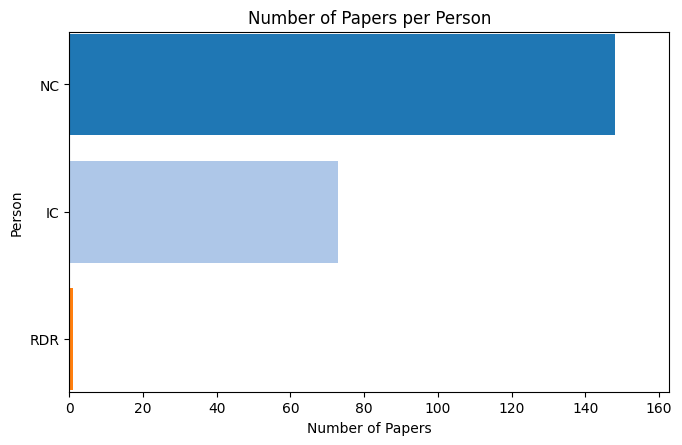

In [25]:
# Plot the horizontal bar graph with spacing between bars
person_counts = df['Person'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(person_counts.index, person_counts.values, color=cm.tab20.colors[:len(person_counts)])
# Set the x-axis label
max_count = person_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Papers')
plt.ylabel('Person')
plt.title('Number of Papers per Person')

# for i, v in enumerate(person_counts.values):
#         plt.text(v + 1, i, str(v))

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=0.5, bottom=0.05)
# plt.grid(axis='x', linestyle='--', alpha=0.3)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()